# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, Iterator, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from decoder import Decoder
from encoder import Encoder
from attention import Attention
# others
from NMTutils import get_parser, build_data, get_model_config, evaluation, BLEU, show_attention
import random
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.cuda.current_device()
# USE_CUDA = False
# DEVICE = -1

## Prepare Loader

In [4]:
lang1 = 'eng'
lang2 = 'fra'
modelcode_small = ['111301', '111311', '111301', '111311', '111311', 
                  '111311', '111311', '122421', '122521', '122621',
                  '122622', '222421', '222521', '222421']
modelcode_filtered = ['322421', '322421', '322421']

## architecture

![](./pics/encoder_decoder_att.png)

---

## Build Networks

In [5]:
def build(config, SOURCE, TARGET):
    enc = Encoder(len(SOURCE.vocab), config.EMBED, config.HIDDEN, config.NUM_HIDDEN, bidrec=True)
    dec = Decoder(len(TARGET.vocab), config.EMBED, 2*config.HIDDEN, hidden_size2=config.HIDDEN2, \
                  sos_idx=SOURCE.vocab.stoi['<s>'], method=config.METHOD, USE_CUDA=USE_CUDA)
    if USE_CUDA:
        enc = enc.cuda()
        dec = dec.cuda()

    loss_function = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi['<pad>'])
    return enc, dec, loss_function

In [6]:
def build_model(model_idx, code, lang1, lang2, file_path='./data/en_fa/', file_type='small', device=-1):
    config, test_data, test_loader, SOURCE, TARGET = get_model_config(code, lang1, lang2, device=device,
                                                                      file_path=file_path, file_type=file_type)
    enc, dec, loss_function = build(config, SOURCE, TARGET)
    enc.eval()
    dec.eval()
    
    enc_model_path = './data/model/{0}_{1}/{0}-{1}{2}.enc'.format(lang1, lang2, model_idx)
    dec_model_path = './data/model/{0}_{1}/{0}-{1}{2}.dec'.format(lang1, lang2, model_idx)
    enc.load_state_dict(torch.load(enc_model_path))
    dec.load_state_dict(torch.load(dec_model_path))
    return enc, dec, loss_function, test_loader, test_data

## Load model parameters & test

It's not proper way using "cross entropy loss" to measure translation is translated well. Better use BLEU score.

In [7]:
for i, code in enumerate(modelcode_small, 1):
    enc, dec, loss_function, test_loader, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                                          file_type='small', device=DEVICE)
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 1 | test_losses: 3.360829508304596
model 2 | test_losses: 2.8594016313552855
model 3 | test_losses: 2.1402396500110625
model 4 | test_losses: 2.0214749455451964
model 5 | test_losses: 2.0058552742004396
model 6 | test_losses: 1.9547790884971619
model 7 | test_losses: 1.9075873076915741
model 8 | test_losses: 2.048448437452316
model 9 | test_losses: 2.1190561950206757
model 10 | test_losses: 2.944315695762634
model 11 | test_losses: 2.0271649777889253
model 12 | test_losses: 2.0206119775772096
model 13 | test_losses: 2.2334439516067506
model 14 | test_losses: 2.204212784767151


In [8]:
for i, code in enumerate(modelcode_filtered, 15):
    enc, dec, loss_function, test_loader, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                                          file_type='filtered', device=DEVICE)
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 15 | test_losses: 2.199807369709015
model 16 | test_losses: 2.222989785671234
model 17 | test_losses: 2.189495933055878


## Visualize Attention And Scroing

### BLEU

1. Prepare a data set, 1 source to many references sentences.
2. Count **N-Gram** in hypothesis(which is your output sentences): $Count(Ngram)$
3. For **N-Gram** words, count these words in references sentences: $Count_{clip}(Ngram)$
4. Combine:
$$p_n = \dfrac{\sum_{Ngram \in y} Count_{clip}(Ngram)}{\sum_{Ngram \in y} Count(Ngram)}$$
5. Calculate BLEU score:
$$BLEU = BP \times \exp(\dfrac{1}{N} \sum_{n=1}^N p_n)$$
which, $BP= \begin{cases}1\quad if\ len(hypothesis) > len(reference) \\ 
\exp(1-\frac{len(hypothesis)}{len(reference)}) \quad otherwise \end{cases}$ 


Why not use Precision?

$$Precision = \dfrac{TRUE\ detections}{whole\ detections\ of\ an\ algorithm}$$

**Precision** means how many apperance of a word that the model predicted are detected in the reference sentences. Like example below

Target:
* Ref1: The cat on the mat
* Ref2: There is a cat on the mat

Output:
* the the the the the the the 

If we use **Precision**, Output Precision = 7/7

Sometimes we modify **TRUE detections** to use the maximum counts of a word in a sentence. But it is not enough to score a sentence generatation.


======== Model 1 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je aurais pu de vous excuser .
BLEU Score:  0.2816
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


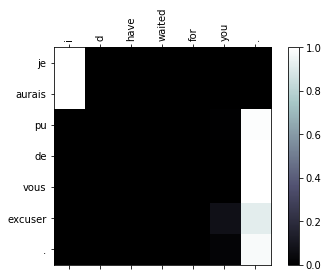

======== Model 2 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je vous je pour vous .
BLEU Score:  0.245
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


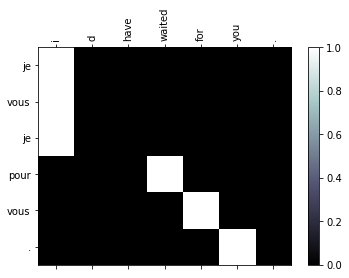

======== Model 3 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  les je ai attendu . .
BLEU Score:  0.245
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


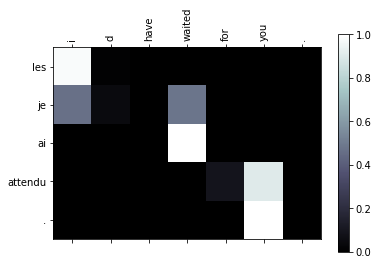

======== Model 4 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je vous ai attendu .
BLEU Score:  0.3365
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


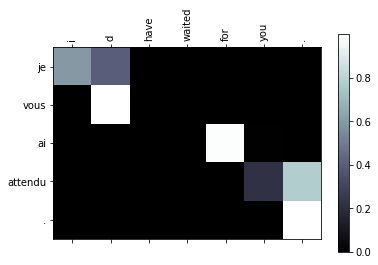

======== Model 5 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je ai ai attendu vous
BLEU Score:  0.2616
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


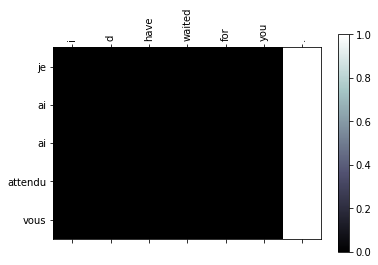

======== Model 6 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je vous attendu attendu .
BLEU Score:  0.3365
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


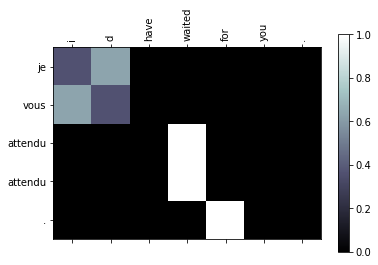

======== Model 7 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je vous ai attendu attendu .
BLEU Score:  0.3131
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


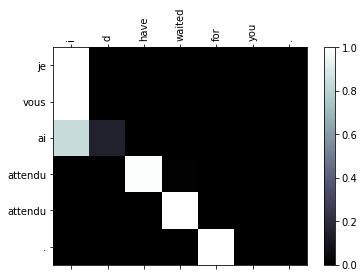

======== Model 8 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  attendu vous attendu . .
BLEU Score:  0.2634
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


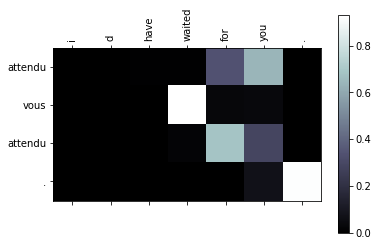

======== Model 9 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  j aurais avoir pour vous .
BLEU Score:  0.2626
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


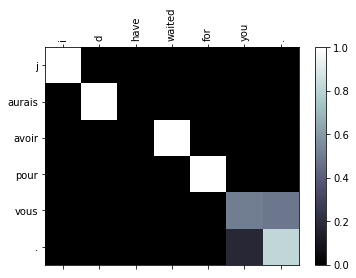

======== Model 10 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  je vous aime tous .
BLEU Score:  0.2634
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


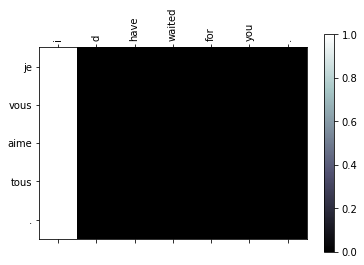

======== Model 11 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  j vous attendu pour .
BLEU Score:  0.2616
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


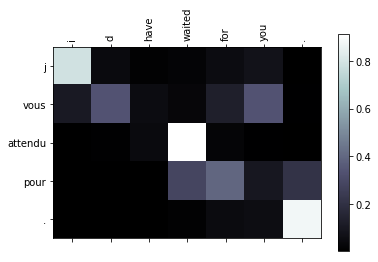

======== Model 12 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  j vous vous pour .
BLEU Score:  0.2364
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


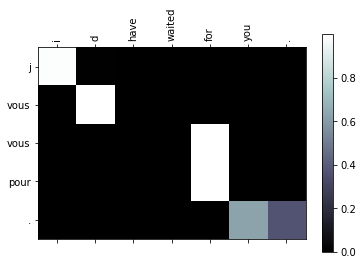

======== Model 13 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  j ai ai vous vous . .
BLEU Score:  0.2368
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


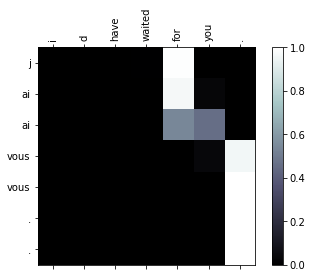

======== Model 14 ========
Source :  i d have waited for you .
Truth :  je t aurais attendu .
Prediction :  j vous en attendu .
BLEU Score:  0.2634
References:  ['je t aurais attendu .', 'je vous aurais attendu .', 'je t aurais attendue .', 'je vous aurais attendue .', 'je vous aurais attendus .', 'je vous aurais attendues .']


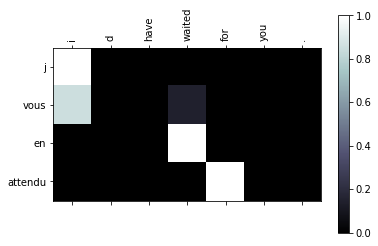

In [10]:
i = 1
file_type = 'small'
model_type = modelcode_small

_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)
bleu = BLEU(test_data, smooth=4)

choose = True
while choose:
    test = random.choice(test_data)
    source_sentence = test.so
    target_sentence = test.ta
    if len(bleu.so_ret_dict[' '.join(source_sentence)]) >= 2:
        choose = False

# change start and target tokens to LongTensor
s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 1):
    enc, dec, _, _, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                    file_type=file_type, device=DEVICE)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    score, ref = bleu.evaluation_bleu(soruce_sentence=' '.join(source_sentence), 
                                      hypotheses=pred_sentence, 
                                      get_ref=True)
    
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))
    print('BLEU Score: ', round(score, 4))
    print('References: ', ref)
    
    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])

======== Model 15 ========
Source :  that never even crossed my mind .
Truth :  cela ne m a jamais effleure l esprit .
Prediction :  cela ne m a pas l esprit .
BLEU Score:  0.4412
References:  ['cela ne m a jamais traverse l esprit .', 'cela ne m a jamais effleure l esprit .']


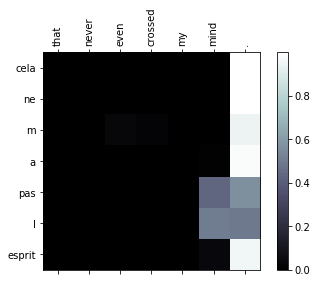

======== Model 16 ========
Source :  that never even crossed my mind .
Truth :  cela ne m a jamais effleure l esprit .
Prediction :  cela ne m m meme meme a a l tete .
BLEU Score:  0.221
References:  ['cela ne m a jamais traverse l esprit .', 'cela ne m a jamais effleure l esprit .']


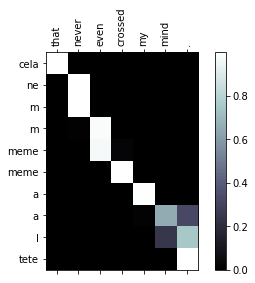

======== Model 17 ========
Source :  that never even crossed my mind .
Truth :  cela ne m a jamais effleure l esprit .
Prediction :  cela cela ne a jamais jamais jamais a l
BLEU Score:  0.2801
References:  ['cela ne m a jamais traverse l esprit .', 'cela ne m a jamais effleure l esprit .']


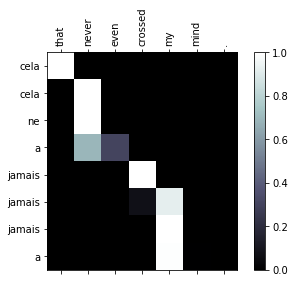

In [15]:
i = 1
file_type = 'filtered'
model_type = modelcode_filtered

_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)
bleu = BLEU(test_data, smooth=4)

choose = True
while choose:
    test = random.choice(test_data)
    source_sentence = test.so
    target_sentence = test.ta
    if len(bleu.so_ret_dict[' '.join(source_sentence)]) >= 2:
        choose = False

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 15):
    enc, dec, _, _, _ = build_model(i, code, lang1, lang2, file_path='./data/en_fa/', 
                                    file_type=file_type, device=DEVICE)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    # metrics
    score, ref = bleu.evaluation_bleu(soruce_sentence=' '.join(source_sentence), 
                                      hypotheses=pred_sentence, 
                                      get_ref=True)
    
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))
    print('BLEU Score: ', round(score, 4))
    print('References: ', ref)

    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])

In [38]:
hypo = 'je sais que vous avez ete occupe .'
refs = ['je sais que tu as ete occupe .', 'je sais que vous avez ete occupe .', 
        'je sais que vous avez ete occupee .', 'je sais que vous avez ete occupes .', 
        'je sais que vous avez ete occupees .', 'je sais que tu as ete occupee .']

In [34]:
from nltk.translate.bleu_score import sentence_bleu

In [39]:
sentence_bleu(references=[x.split() for x in refs], hypothesis=hypo.split())

1.0

In [52]:
smmoth_function = SmoothingFunction()

In [74]:
hypo = 'j ai pu ete ete .'
refs = ['j ai ete mal compris .', 'j ai ete mal comprise .', 'je fus mal compris .', 'je fus mal comprise .']
    
for i in range(8):
    bleu = BLEU(test_data, smooth=i)
    s = sentence_bleu(references=[x.split() for x in refs], hypothesis=hypo.split(), 
                  smoothing_function=smmoth_function.__getattribute__('method{}'.format(i)))
    print(i, s)

0 9.013778876140909e-155
1 0.10266900960803409
2 0.3303164318013807
3 0.19304869754804482
4 0.26330448460358885
5 0.19060087794444558


/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


AssertionError: This smoothing method requires non-zero precision for bigrams.